<a href="https://colab.research.google.com/github/lawsonk16/Object-Detection/blob/main/FasterRcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Model

<i> Note: These paths are not universal - they are relative and require the user to set up their own data directory. With Colab it is difficult to do otherwise. </i>


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Step 1: Make Relevant Imports
We have defined many custom scripts, so we need to add them to our system path

In [ ]:
! pip install terminaltables

import sys
paths = ['/content/drive/MyDrive/Colab Notebooks/scripts']

for p in paths:
    sys.path.append(p)

import os
import json
import shutil

from coco_utils.pytorch_coco_detect import *
from ensemble import *
from coco_utils.coco_help import *

### Step 2: Unzip Data, Set Data Paths and Create Data Loaders

In [ ]:
data_zip_path = '/content/drive/MyDrive/Colab Notebooks/Clean Datasets/FAIR1M/500/FAIR1M_500_mini_10.zip'
data_path = '/content/'

# shutil.copy2(data_zip_path, data_path)

# shutil.unpack_archive(data_zip_path.split('/')[-1])
# os.remove(data_zip_path.split('/')[-1])

In [ ]:
# change the data tag to match your dataset, if applicable
data_tag = 'FAIR1M_500'

train_ims = 'train_images/'
val_ims = 'val_images/'
test_ims = 'test_images/'

train_anns = f'train_{data_tag}_gt.json'
val_anns = f'val_{data_tag}_gt.json'
test_anns = f'test_{data_tag}_gt.json'

In [ ]:
num_workers = 0
train_batch_size = 8
train_data_loader = make_train_loader(train_ims, train_anns, train_batch_size, num_workers)

num_workers = 0
val_batch_size = 1
val_data_loader = make_test_loader(val_ims, val_anns, val_batch_size, num_workers)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


### Part 3: Prepare the Model
 - Create a model name for experiments with these hyperparameters
   - If previous training has occurred, this will be the path where that info is stored
 - Load a model of the correct depth

In [ ]:
# Check the number of catgeories
with open(train_anns, 'r') as f:
    gt = json.load(f)

cats = gt['categories']

In [ ]:
### Modify these variables for your experiment ###
exp_folder = '/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/'
data_name = 'FAIR1M'
data_split = 'Train-50_Val-20_Test-30_mini_10_train-loss'

resnet_backbone = 50
num_classes = len(cats) + 1

optim = 'SGD'
lr = 0.0001
mom = 0.9
wd = 0.0005
pretrained = True

model_path = name_model(exp_folder, data_name, data_split, resnet_backbone, train_batch_size, num_classes, optim, lr, mom, wd, pretrained)
model_path

'/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/FAIR1M/Train-50_Val-20_Test-30_mini_10_train-loss/resnet50fpn/classes_38_optim_SGD_lr_0p0001_mom_0p9_wd_0p0005_pretrained_True_batch_8/best_weights.pt'

### Part 4: Train the Model 
Set a few more hyperparameters, and display precision and recall on validation set at a frequency you set

In [ ]:
# Choose a total number of epochs to train with this configuration
num_epochs = 50

# Evaluation Criteria
start_eval_epoch = 5
eval_freq = 10
iou_nms = 0.8

# How often to save
save_freq = 10

# wrap up the data
data_loaders = [train_data_loader, val_data_loader]

# get the model
model = get_fasterrcnn(num_classes, pretrained, resnet_backbone)

losses = train_fasterrcnn(model, model_path, data_loaders, 
                                optim, lr, mom, wd, 
                                num_epochs, start_eval_epoch, eval_freq, iou_nms, save_freq)

Loading 25 epochs of training for fasterrcnn
Training epoch 26 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.93it/s]


Training epoch 27 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.92it/s]


Training epoch 28 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.93it/s]


Training epoch 29 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.90it/s]


Training epoch 30 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.96it/s]


Evalutation on epoch 30


Getting val detections: 100%|██████████| 615/615 [00:43<00:00, 14.24it/s]


Saved model history
Training epoch 31 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.95it/s]


Training epoch 32 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.87it/s]


Training epoch 33 of 50


Validation: 100%|██████████| 615/615 [00:43<00:00, 13.99it/s]


Training epoch 34 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.96it/s]


Training epoch 35 of 50


Validation: 100%|██████████| 615/615 [00:43<00:00, 14.00it/s]


Training epoch 36 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.95it/s]


Training epoch 37 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.96it/s]


Training epoch 38 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.97it/s]


Training epoch 39 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.96it/s]


Training epoch 40 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.95it/s]


Evalutation on epoch 40


Getting val detections: 100%|██████████| 615/615 [00:43<00:00, 14.26it/s]


Saved model history
Training epoch 41 of 50


Validation: 100%|██████████| 615/615 [00:43<00:00, 13.99it/s]


Training epoch 42 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.94it/s]


Training epoch 43 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.92it/s]


Training epoch 44 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.97it/s]


Training epoch 45 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.93it/s]


Training epoch 46 of 50


Validation: 100%|██████████| 615/615 [00:43<00:00, 13.98it/s]


Training epoch 47 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.95it/s]


Training epoch 48 of 50


Validation: 100%|██████████| 615/615 [00:43<00:00, 13.98it/s]


Training epoch 49 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.92it/s]


Training epoch 50 of 50


Validation: 100%|██████████| 615/615 [00:44<00:00, 13.94it/s]


Evalutation on epoch 50


Getting val detections: 100%|██████████| 615/615 [00:43<00:00, 14.30it/s]


Saved model history


## Part 5: Evaluate

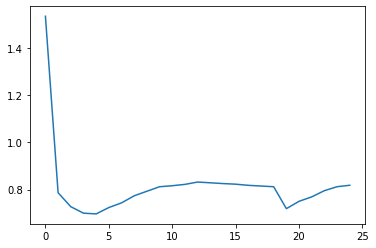

In [ ]:
plt.plot(range(0, len(losses)), losses)

In [ ]:
train_dt_path, val_dt_path = get_most_recent_dts(model_path)
train_dt_path, val_dt_path

('/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/FAIR1M/Train-50_Val-20_Test-30_mini_10_train-loss/resnet50fpn/classes_38_optim_SGD_lr_0p0001_mom_0p9_wd_0p0005_pretrained_True_batch_8/detections/train_19_epochs_0p8_iou-nms.json',
 '/content/drive/MyDrive/Colab Notebooks/Experiments/Detection/FAIR1M/Train-50_Val-20_Test-30_mini_10_train-loss/resnet50fpn/classes_38_optim_SGD_lr_0p0001_mom_0p9_wd_0p0005_pretrained_True_batch_8/detections/val_19_epochs_0p8_iou-nms.json')

In [ ]:
conf_thresh = 0.0

# Detections
train_dts = yolo_coco_dts(train_anns, train_dt_path, conf_thresh)
val_dts = yolo_coco_dts(val_anns, val_dt_path, conf_thresh)

# Ground Truth
train_gt = yolo_coco_gt(train_anns)
val_gt = yolo_coco_gt(val_anns)

100%|██████████| 615/615 [00:00<00:00, 1499.35it/s]


In [ ]:
from collections import Counter

dts_classes = []
for im_dts in val_dts:
    if im_dts != None:
        for dt in im_dts:
            dts_classes.append(int(dt[-1].numpy()))
# Counter(dts_classes)

Counter({9: 10651, 10: 5283, 19: 5, 24: 568, 26: 3, 29: 1580})

In [ ]:
gts_classes = []
for dt in train_gt:
    gts_classes.append(int(dt[1].numpy()))
# Counter(gts_classes)

Counter({0: 293,
         1: 60,
         2: 339,
         3: 141,
         4: 29,
         5: 22,
         6: 86,
         7: 142,
         8: 90,
         9: 5627,
         10: 5235,
         11: 44,
         12: 45,
         13: 5,
         14: 1108,
         15: 404,
         16: 9,
         17: 24,
         18: 140,
         19: 134,
         20: 62,
         21: 48,
         22: 62,
         23: 3,
         24: 239,
         25: 115,
         26: 73,
         27: 38,
         28: 4,
         29: 409,
         30: 42,
         31: 30,
         32: 136,
         33: 47,
         34: 303,
         35: 28,
         36: 40})

<Figure size 432x288 with 0 Axes>

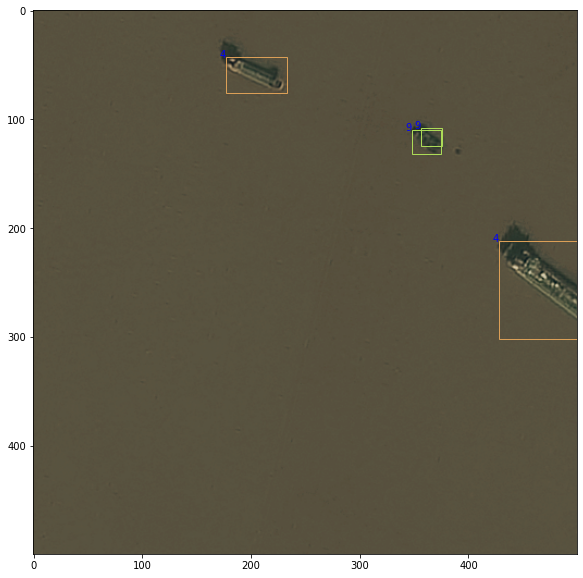

<Figure size 432x288 with 0 Axes>

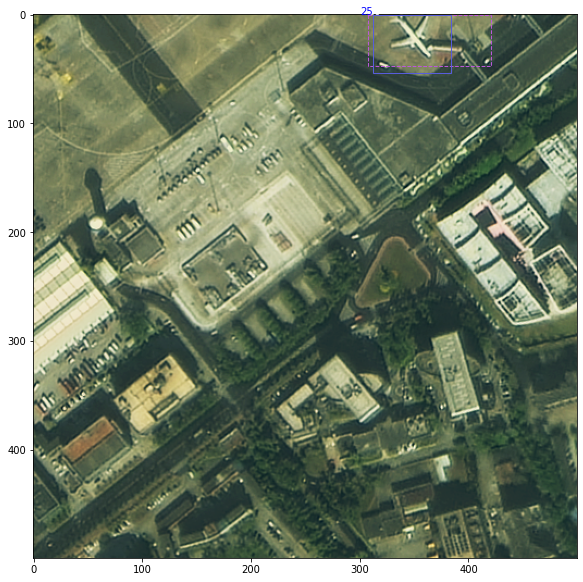

In [ ]:
display_random_gt_dt(2, val_anns, val_dt_path, val_ims, (10,10), 0.0)

In [ ]:
def display_random_gt_dt(num_ims, gt_path, dt_path, image_folder, fig_size = (20,20), conf_thresh = 0.9):
    '''
    PURPOSE: Display some number of images from a coco dataset, randomly selected
    IN:
        -num_ims: int indicating how many to display
        -json_path: coco gt file
        -image_folder: folder where images in json_path are located
    OUT:
        -figures with each randomly selected image and its annotations
    '''

    with open(gt_path, 'r') as f:
        gt_content = json.load(f)

    # Get Color palette
    pal = make_palette(gt_content)
    
    # Pick the image ids to display
    ims = choose_random_ims(num_ims, gt_content)
    
    with open(gt_path, 'r') as f:
        gt = json.load(f)
        
    # Process each image
    for i in ims:
        
        images = gt['images']
        for im in images:
            if im['id'] == i:
                im_name = im['file_name']
        
        # Get annotations on this image
        anns_dt = anns_on_image_dt(i, dt_path)
        anns_gt = anns_on_image(i, gt_content)
        
        # Display the image
        im_path = image_folder + im_name
        plt.figure()
        f,ax = plt.subplots(1, figsize = fig_size)
        img = plt.imread(im_path)
        plt.imshow(img)
        for a in anns_dt:
            b = a['bbox']
            cat = a['category_id']
            conf = a['score']
            if conf >= conf_thresh:
                cat_name = get_category_gt(cat, gt)
                rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none", ls = '--')
                plt.text(b[0], b[1], cat, ha = "left", color = 'w')
                ax.add_patch(rect)
        for a in anns_gt:
            b = a['bbox']
            cat = a['category_id']
            cat_name = get_category_gt(cat, gt)
            rect = patches.Rectangle((b[0], b[1]), b[2], b[3], edgecolor = pal[cat-1], facecolor = "none", ls = '-')
            plt.text(b[0], b[1], cat, ha = "right", color = 'b')
            ax.add_patch(rect)
        plt.show()
    
    return


In [ ]:
import json
with open(train_anns, 'r') as f:
    train_data = json.load(f)
clss = train_data['categories']

class_names = []

for c in clss:
    class_names.append(c['name'])

In [ ]:
iou_thresh = 0.05
evaluate_coco(val_dts, val_gt, class_names, iou_thresh)

Computing AP: 100%|██████████| 35/35 [00:00<00:00, 707.94it/s]

+-------+-------------------+---------+
| Index | Class name        | AP      |
+-------+-------------------+---------+
| 0     | Dry Cargo Ship    | 0.00000 |
| 1     | Engineering Ship  | 0.00000 |
| 2     | Motorboat         | 0.00000 |
| 3     | Liquid Cargo Ship | 0.00000 |
| 4     | Warship           | 0.00000 |
| 5     | Passenger Ship    | 0.00000 |
| 6     | Tugboat           | 0.00000 |
| 7     | Fishing Boat      | 0.00000 |
| 8     | other-ship        | 0.00000 |
| 9     | Small Car         | 0.00000 |
| 10    | Van               | 0.00000 |
| 11    | Bus               | 0.00000 |
| 12    | Excavator         | 0.00000 |
| 14    | Dump Truck        | 0.00000 |
| 15    | Cargo Truck       | 0.00000 |
| 16    | Truck Tractor     | 0.00000 |
| 17    | Trailer           | 0.00000 |
| 18    | other-vehicle     | 0.00000 |
| 19    | Boeing737         | 0.00000 |
| 20    | Boeing747         | 0.00000 |
| 21    | Boeing777         | 0.00000 |
| 22    | Boeing787         | 0.00000 |


In [ ]:
from __future__ import division
import math
import time
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from terminaltables import AsciiTable

import sys
paths = ['/content/drive/MyDrive/Colab Notebooks/scripts']

for p in paths:
    sys.path.append(p)

from coco_utils.coco_help import get_im_ids


def to_cpu(tensor):
    return tensor.detach().cpu()


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

def evaluate(model, path, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(path, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (_, imgs, targets) in enumerate(tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class

def evaluate_coco(outputs, targets, class_names, iou_thresh = 0.5):

    sample_metrics = get_batch_statistics(outputs, targets, iou_threshold=iou_thresh)

    labels = targets[:, 1].tolist()

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    # Print class APs and mAP
    ap_table = [["Index", "Class name", "AP"]]
    for i, c in enumerate(ap_class):
        ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
    print(AsciiTable(ap_table).table)
    print(f"---- mAP {AP.mean()}")
    print(f"---- Precision {precision.mean()}")
    print(f"---- Recall {recall.mean()}")

    return 

def get_latest_dts(folder):
    files = os.listdir(folder)
    latest_epoch = 0
    latest_dts = ''
    for f in files:
        if '.json' in f:
            epoch = int(f.split('_')[-4])
            if epoch > latest_epoch:
                latest_epoch = epoch
                latest_dts = f

    return folder + latest_dts

def get_dts_id(im_id, dts):
    im_dts = []
    for d in dts:
        if d['image_id'] == im_id:
            im_dts.append(d)
    return im_dts


def get_gts_id(im_id, gts):
    im_gts = []
    for d in gts['annotations']:
        if d['image_id'] == im_id:
            im_gts.append(d)
    return im_gts

def yolo_coco_dts(gt_fp, dt_fp, conf_thresh = 0.0):

    # get all image ids in the ground truth
    im_ids = get_im_ids(gt_fp)
    im_ids.sort()

    with open(dt_fp, 'r') as f:
        dts = json.load(f)

    all_dts = []

    for im_id in tqdm(im_ids):
        im_dts = get_dts_id(im_id, dts)
        formatted_dts = []
        for dt in im_dts:

            # bounding box
            bbox = dt['bbox']
            bbox = [float(i) for i in bbox]
            [x1, y1, w, h] = bbox
            x2 = x1 + w
            y2 = y1 + h
            score = dt['score']
            cat = float(dt['category_id']) - 1.0
            dt_formatted = [x1, y1, x2, y2, score, cat]
            if score >= conf_thresh:
                formatted_dts.append(dt_formatted)
        if len(formatted_dts) > 0:
            formatted_dts = torch.Tensor(formatted_dts)
            all_dts.append(formatted_dts)
        else:
            all_dts.append(None)

    return all_dts

def yolo_coco_gt(gt_fp):
    all_gt = []

    im_ids = get_im_ids(gt_fp)
    im_ids.sort()

    with open(gt_fp, 'r') as f:
        gts = json.load(f)
    
    for im_id in tqdm(im_ids):
        im_gts = get_gts_id(im_id, gts)
        for gt in im_gts:
            cat = gt['category_id'] - 1.0
            bbox = gt['bbox']
            bbox = [float(a) for a in bbox]
            [x1, y1, w, h] = bbox
            x2 = x1 + w
            y2 = y1 + h
            im_id = float(im_id)
            f_gt = [im_id, cat, x1, y1, x2, y2]
            all_gt.append(f_gt)

    return torch.Tensor(all_gt)

def get_yolo_dts(dt_folder, pretrained_weights = "/content/PyTorch-YOLOv3/weights/darknet53.conv.74"):
    
    model_weights = os.listdir(dt_folder)

    current_epoch = 0

    for m in model_weights:
        epoch = int(m.split('.')[0].split('_')[-1])
        if epoch > current_epoch:
            current_epoch = epoch
            pretrained_weights = dt_folder + m

    if current_epoch > 0:
        current_epoch += 1

    return current_epoch, pretrained_weights

def get_overlapped_dts(detections_1, detections_2, nms_thresh = 0.5):

    dts_match = []

    for i, dts_1 in enumerate(tqdm(detections_1)):
        dts_2 = detections_2[i]
        im_dts_1 = []
        if dts_1 is not None and dts_2 is not None:
            for dt in dts_1:
                dts_overlap = bbox_iou(dt.unsqueeze(0), dts_2[:, :4]) > nms_thresh
                class_match = dt[-1] == dts_2[:,-1]
                match = dts_overlap & class_match
                match_dts_2 = dts_2[match]
                if sum(match) > 0:
                    im_dts_1.append(dt.tolist())
                    for dt_2 in match_dts_2:
                        im_dts_1.append(dt_2.tolist())
            if len(im_dts_1) > 0:
                dts_match.append(torch.Tensor(im_dts_1))
            else:
                dts_match.append(None)
            
        else:
            dts_match.append(None)

    return dts_match


def nms(prediction, conf_thres=0.3, nms_thres=0.8):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, class_score, class_pred)
    """

    
    output = [None for _ in range(len(prediction))]

    for image_i, image_pred in enumerate(prediction):
        
        if image_pred is not None:
            
            image_pred = image_pred[image_pred[:, 4] >= conf_thres]
            # If none are remaining => process next image
            if not image_pred.size(0):
                continue
            # Class score
            score = image_pred[:, 4]
            # Sort by it
            image_pred = image_pred[(-score).argsort()]
            # Key info
            class_confs, _ = image_pred[:, 4:5].max(1, keepdim=True)
            class_preds, _ = image_pred[:, 5:].max(1, keepdim=True)
            detections = torch.cat((image_pred[:, :4], class_confs.float(), class_preds.float()), 1)

            # Perform non-maximum suppression
            keep_boxes = []
            while detections.size(0):
                large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
                label_match = detections[0, -1] == detections[:, -1]
                # Indices of boxes with lower confidence scores, large IOUs and matching labels
                invalid = large_overlap & label_match
                weights = detections[invalid, 4:5]
                # Merge overlapping bboxes by order of confidence
                detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
                keep_boxes += [detections[0]]
                detections = detections[~invalid]
            if keep_boxes:
                output[image_i] = torch.stack(keep_boxes)

    return output
    

def merge_dts(detections_1, detections_2):
    merged_dts = []
    for i, dts_1 in enumerate(tqdm(detections_1)):
        dts_2 = detections_2[i]
        merged = []

        # process detections from the first set
        if dts_1 is not None:
            dts_1 = dts_1.tolist()
            merged.extend(dts_1)

        # process detections from the second set
        if dts_2 is not None:
            dts_2 = dts_2.tolist()
            merged.extend(dts_2)
        
        # handle the 'None' case
        if len(merged) < 1:
            merged_dts.append(None)

        # add the detections to the larger list
        else:
            merged_dts.append(torch.Tensor(merged))

    return merged_dts